# Sparse Matrices 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('notebook', font_scale=1.5)

## A review of the essentials

There are many applications in which we deal with matrices that are mostly zeros. For example, a matrix representing a text corpus is very sparse - there are many thousands of words used but each document only uses a small subset of the total. Social networks are similar because there are a lot of people, but most people are only connected to a few hundred or thousand others directly. Storing such a social network as a sparse rather than dense matrix  will offer orders of magnitude reductions in memory requirements and corresponding speed-ups in computation.

### Coordinate format

The simplest sparse  matrix format is built from the coordinates and values of the non-zero entries.

#### From dense matrix

In [3]:
A = np.random.poisson(0.2, (5,15)) * np.random.randint(0, 10, (5, 15))
A

array([[0, 0, 0, 0, 7, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 7, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0],
       [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0]])

In [4]:
rows, cols = np.nonzero(A)
vals = A[rows, cols]

In [5]:
vals

array([7, 6, 2, 1, 7, 3, 7, 4, 6, 5, 3])

In [6]:
rows

array([0, 0, 0, 1, 1, 1, 3, 3, 3, 4, 4])

In [7]:
cols

array([ 4,  6,  7,  2,  4,  8,  1,  3,  6,  0, 13])

In [8]:
X1 = sparse.coo_matrix(A)
X1

<5x15 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in COOrdinate format>

In [9]:
print(X1)

  (0, 4)	7
  (0, 6)	6
  (0, 7)	2
  (1, 2)	1
  (1, 4)	7
  (1, 8)	3
  (3, 1)	7
  (3, 3)	4
  (3, 6)	6
  (4, 0)	5
  (4, 13)	3


#### From coordinates

Note that the (values, (rows, cols)) argument is a single tuple.

In [10]:
X2 = sparse.coo_matrix((vals, (rows, cols)))
X2

<5x14 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in COOrdinate format>

In [11]:
print(X2)

  (0, 4)	7
  (0, 6)	6
  (0, 7)	2
  (1, 2)	1
  (1, 4)	7
  (1, 8)	3
  (3, 1)	7
  (3, 3)	4
  (3, 6)	6
  (4, 0)	5
  (4, 13)	3


#### Convert back to dense matrix

In [12]:
X2.todense()

matrix([[0, 0, 0, 0, 7, 0, 6, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 7, 0, 0, 0, 3, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 7, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

## Compressed Sparse Row and Column formats

When we have repeated entries in the rows or cols, we can remove the redundancy by indicating the  location of the  first occurrence of a value and its increment instead of the full coordinates. Note that the final index location  must be the number of rows or cols since there is no other way to know the shape. These are known as CSR or CSC formats.

In [13]:
np.vstack([rows, cols])

array([[ 0,  0,  0,  1,  1,  1,  3,  3,  3,  4,  4],
       [ 4,  6,  7,  2,  4,  8,  1,  3,  6,  0, 13]])

In [14]:
indptr = np.r_[np.searchsorted(rows, np.unique(rows)), len(rows)]
indptr

array([ 0,  3,  6,  9, 11])

In [15]:
X3 = sparse.csr_matrix((vals, cols, indptr))
X3

<4x14 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [16]:
print(X3)

  (0, 4)	7
  (0, 6)	6
  (0, 7)	2
  (1, 2)	1
  (1, 4)	7
  (1, 8)	3
  (2, 1)	7
  (2, 3)	4
  (2, 6)	6
  (3, 0)	5
  (3, 13)	3


In [17]:
X3.todense()

matrix([[0, 0, 0, 0, 7, 0, 6, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 7, 0, 0, 0, 3, 0, 0, 0, 0, 0],
        [0, 7, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

#### Casting from COO format

Because the coordinate format is more intuitive, it is often more convenient to first create a COO matrix then cast to CSR or CSC form.

In [18]:
X4 = X2.tocsr()

In [19]:
X4

<5x14 sparse matrix of type '<class 'numpy.longlong'>'
	with 11 stored elements in Compressed Sparse Row format>

In [20]:
rows = np.repeat([0,1], 4)
cols = np.repeat([0,1], 4)
vals = np.arange(8)

In [21]:
rows

array([0, 0, 0, 0, 1, 1, 1, 1])

In [22]:
cols

array([0, 0, 0, 0, 1, 1, 1, 1])

In [23]:
vals

array([0, 1, 2, 3, 4, 5, 6, 7])

In [24]:
X5 = sparse.coo_matrix((vals, (rows, cols)))

In [25]:
X5.todense()

matrix([[ 6,  0],
        [ 0, 22]])

## Question 1: Preparing the data

Read in the data in from `airports.csv` and `names.csv`.  We are interested in the following columns

* ORIGIN_AIRPORT_ID	
* DEST_AIRPORT_ID

The second file will help us figure out what each code means

Read both into data frames in a way that will allow you to lookup the `description` of an airport based on its ID.

In [ ]:
## ANSWER
data = pd.read_csv('data/airports.csv', usecols=[0,1])
lookup = pd.read_csv('data/names.csv', index_col=0)

## Question 2: Summarize the data

print out summarizing data that helps you understand the data set.

In [54]:
print("there are {} entries in the data set".format(data.shape[0]))
print("there are {} ORIGIN AIRPORTS".format(np.unique(data["ORIGIN_AIRPORT_ID"]).size))
print("there are {} DEST AIRPORTS".format(np.unique(data["DEST_AIRPORT_ID"]).size))
print("there are {} DESCRIBED AIRPORTS".format(np.unique(lookup.index.tolist()).size))

there are 445827 entries in the data set
there are 294 ORIGIN AIRPORTS
there are 294 DEST AIRPORTS
there are 6404 DESCRIBED AIRPORTS


## Solving large sparse linear systems

SciPy provides efficient routines for solving large sparse systems as for dense matrices. We will illustrate by calculating the page rank  for airports using data from the [Bureau of Transportation Statisitcs](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236). The [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm is used to rank web pages for search results, but it can be used to rank any node in a directed graph (here we have airports instead of web pages). PageRank is fundamentally about finding the steady state in a Markov chain and can be solved as a linear system.

The update at each time step for the page rank $PR$ of a page $p_i$ is 

![i0](https://wikimedia.org/api/rest_v1/media/math/render/svg/8a8c0a807f62331cc1740dd6c0f28ac1809926c7)

In the above equation, $B_u$ is the set of all nodes $v$ that link to $u$, where each $v$ node contributes its page rank divided by its number of outgoing links $L(v)$. So a node $v$ with a high page rank contributes a large value to a linked node $u$ if $v$ has relatively few other links. 

The figure shows a network with four nodes, all of which start with a page rank of $1/4$. The values on the edges shows how much of its page rank one nodes contributes to its linked nodes in the first step.

By letting the sum of all page ranks to be equal to one, we essentially have a probability distribution over the nodes of the graph. Since the state of the graph only depends on its previous state, we have a Markov chain. If we assume that every node can be reached from every other node, the system will have a steady state - which is what the PageRank algorithm seeks to find. To guard against case where a node has out-degree 0, we allow every node a small random chance of transitioning to any other node using a damping factor $d$. Then we solve  the linear system  to find the pagerank score $R$.


![i1](https://wikimedia.org/api/rest_v1/media/math/render/svg/6bb0f1469218a064274fd4691143e9ce64639dc2)

In matrix notation, this is

![i2](https://wikimedia.org/api/rest_v1/media/math/render/svg/96265e6c41318e793194287f36b5f929075bb876)

where

![i2.5](https://wikimedia.org/api/rest_v1/media/math/render/svg/3e82b446a376633a386b10668703a4547f167d1c)

At steady state,

![i3](https://wikimedia.org/api/rest_v1/media/math/render/svg/65d2fed50688deaca4640b117c88a9e7a3c2ef0d)

and we can rearrange terms to solve for $R$

![i4](https://wikimedia.org/api/rest_v1/media/math/render/svg/985f19f0c6b69d3a8afb5acc38339ebe4915baa7)



## Working with graphs 

We will use the Python package NetworkX for this example, but later in the week we will dig into this package.

In [26]:
import networkx as nx

## Question 3: create matrix that represents a graph

Use the following code to construct an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix), using the package NetworkX.

```python

g = nx.from_pandas_edgelist(data, source='ORIGIN_AIRPORT_ID', target='DEST_AIRPORT_ID')
airports = np.array(g.nodes())
adj_matrix = nx.to_scipy_sparse_matrix(g)
```

1. What kind of matrix are we working with?
2. Calculate the sparsity
3. Also stage the adjacency matrix for future use (save it to disk).

In [92]:
## Answer
g = nx.from_pandas_edgelist(data, source='ORIGIN_AIRPORT_ID', target='DEST_AIRPORT_ID')
airports = np.array(g.nodes())
adj_matrix = nx.to_scipy_sparse_matrix(g)

print("object type", type(adj_matrix))
sparsity = 1.0 - (adj_matrix.count_nonzero() / adj_matrix.shape[0]**2)

## or because it is a fairly small matrix
A = adj_matrix.todense()
print('sparsity',round(1.0 - (np.count_nonzero(A) / A.size),3))

file_name = "airport_smatrix.npz"
sparse.save_npz(file_name, adj_matrix)
AA = sparse.load_npz(file_name)
print("object loaded from file", AA.shape)

object type <class 'scipy.sparse.csr.csr_matrix'>
sparsity 0.953
object loaded from file (294, 294)


## Question 4: Construct the transition matrix

These are the necessary steps to construct a [transition matrix](https://en.wikipedia.org/wiki/Stochastic_matrix)

1. determine the out degree (the number of outward edges connected to a node)

The output will be a `np.array` with 294 elements each corresponding to the number of outbound flights

2. Create a diag_matrix using `scipy.sparse.diag` that uses `1/out_degrees`.  Then transform it to a csr matrix.

The matrix should be 294 x 294

3. Use matrix multiplication to multiply the diagonal matrix by the adjacency matrix.  Then transpose the result.

The matrix should be 294 x 294

In [117]:
## Answer
out_degrees = np.ravel(adj_matrix.sum(axis=1))
print(out_degrees.shape)
diag_matrix = sparse.diags(1 / out_degrees).tocsr()
print(diag_matrix.shape)
M = (diag_matrix @ adj_matrix).T
# M = diag_matrix.dot(adj_matrix).T
print(M.shape)

(294,)
(294, 294)
(294, 294)


## Question 5: Create the equation that we need to use to solve for steady states

use the following code to create the equation

```
n = len(airports) 
d = 0.85 
I = sparse.eye(n, format='csc')
A = I - d * M
b = (1-d) / n * np.ones(n) # so the sum of all page ranks is 1
```

For each line write a comment that explains the step in the process

In [121]:
## size of the system
n = len(airports) 

## damping factor (modulated the random chance of transitioning to any other node)
d = 0.85 

## component needed to represent first part of linear system
I = sparse.eye(n, format='csc')

## first part of linear system
A = I - d * M

## second part of linear system
b = (1-d) / n * np.ones(n) # so the sum of all page ranks is 1

print(A.shape)
print(b.shape)

(294, 294)
(294,)


## Question 6: Solve linear system

1. Use [spsolve](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.spsolve.html) to solve the linear system. Each value represents the page rank for a specific airport.

HINT: your result should sum to 1.0

2. use the sorted result to index back into your data to print Description, degree, and page rank.  Print the top 10.


In [38]:
from scipy.sparse.linalg import spsolve

In [39]:
## Answer
r =  spsolve(A, b)
r.sum()

0.9999999999999999

In [40]:
idx = np.argsort(r)
top10 = idx[-10:][::-1]
bot10 = idx[:10]

In [122]:
df = lookup.loc[airports[top10]]
df['degree'] = out_degrees[top10]
df['pagerank']= r[top10]
df

,Description,degree,pagerank
Code,,,
10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",158,0.043286
13930,"Chicago, IL: Chicago O'Hare International",139,0.033956
11292,"Denver, CO: Denver International",129,0.031434
11298,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",108,0.027596
13487,"Minneapolis, MN: Minneapolis-St Paul Internati...",108,0.027511
12266,"Houston, TX: George Bush Intercontinental/Houston",110,0.025967
11433,"Detroit, MI: Detroit Metro Wayne County",100,0.024738
14869,"Salt Lake City, UT: Salt Lake City International",78,0.019298
14771,"San Francisco, CA: San Francisco International",76,0.017820


In [123]:
df = lookup.loc[airports[bot10]]
df['degree'] = out_degrees[bot10]
df['pagerank']= r[bot10]
df

,Description,degree,pagerank
Code,,,
14025,"Plattsburgh, NY: Plattsburgh International",1,0.000693
12265,"Niagara Falls, NY: Niagara Falls International",1,0.000693
16218,"Yuma, AZ: Yuma MCAS/Yuma International",1,0.000693
11695,"Flagstaff, AZ: Flagstaff Pulliam",1,0.000693
14905,"Santa Maria, CA: Santa Maria Public/Capt. G. A...",1,0.000710
14487,"Redding, CA: Redding Municipal",1,0.000710
13964,"North Bend/Coos Bay, OR: Southwest Oregon Regi...",1,0.000710
10157,"Arcata/Eureka, CA: Arcata",1,0.000710
11049,"College Station/Bryan, TX: Easterwood Field",1,0.000711


## Question 7:  Visualize the airport connections graph  (Extra Credit)

NetworkX has many [drawing capabilities](https://networkx.github.io/documentation/stable/reference/drawing.html).  

1. Go through [this tutorial](https://networkx.github.io/documentation/stable/tutorial.html) to familiarize yourself with how to work with graphs. Hint the variable, `g` should still be a NetworkX Graph object. 

2. Use the `Drawing Graphs` section to create a visualization of this network

3. Create a visualization that labels the top 5 airports by pagerank

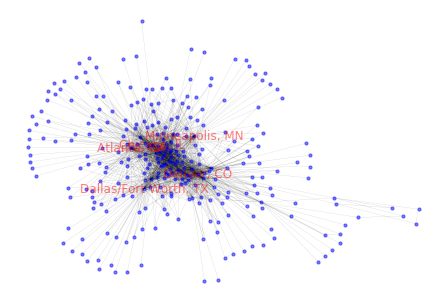

In [126]:
labels = {airports[i]: lookup.loc[airports[i]].str.split(':').str[0].values[0] 
          for i in np.r_[top10[:5]]}

nx.draw(g, pos=nx.spring_layout(g), labels=labels, 
        node_color='blue', font_color='red', alpha=0.5,
        node_size=10, width=0.1)